# 使用 REINFORCE 算法解决平衡杆问题 (CartPole)

在这个Notebook中，我们将实现经典的策略梯度算法——REINFORCE，来训练一个智能体玩`CartPole-v1`游戏。与DQN不同，REINFORCE是一种**基于策略Policy-Based**的方法，它直接学习一个策略函数，该函数将状态映射到动作的概率分布。

**核心思想:**
1.  **策略网络 (Policy Network)**: 使用一个神经网络来参数化策略。网络的输入是环境状态，输出是每个可能动作被选择的概率。
2.  **轨迹采样 (Trajectory Sampling)**: 智能体根据当前策略与环境互动，完成一个完整的游戏回合（episode），并记录下整个轨迹中的状态、动作、奖励。
3.  **策略梯度更新 (Policy Gradient Update)**: 在一个回合结束后，计算每个时间步的未来折扣回报（Return, G_t）。然后，使用这些回报来调整策略网络的参数。目标是增加能够带来更高回报的动作的概率，减少导致较低回报的动作的概率。

$$ \nabla_\theta J(\theta) \approx \sum_{t=0}^{T} G_t \nabla_\theta \ln \pi_\theta(a_t|s_t) $$

其中，$G_t$ 是在时间步 $t$ 的折扣回报，$\pi_\theta(a_t|s_t)$ 是策略网络。

## 1. 环境设置

首先，安装必要的库。我们将使用 `gymnasium` 作为环境库。

In [1]:
!pip install gymnasium torch numpy matplotlib --user

## 2. REINFORCE 算法实现

完整的代码实现，包括策略网络定义和REINFORCE训练函数。

In [2]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# --- 1. 初始化环境和设备 ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

env_id = "CartPole-v1"
env = gym.make(env_id)

# 获取状态和动作空间信息
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____ 观察空间 (Observation Space) _____\n")
print("状态空间维度: ", s_size)
print("一个随机状态样本: ", env.observation_space.sample())
print("\n_____ 动作空间 (Action Space) _____\n")
print("动作空间维度: ", a_size)
print("一个随机动作样本: ", env.action_space.sample())

# --- 2. 定义策略网络 ---
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size) # 输入层到隐藏层
        self.fc2 = nn.Linear(h_size, a_size) # 隐藏层到输出层

    def forward(self, x):
        """定义网络的前向传播"""
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # 使用 softmax 将输出转换为动作概率分布
        return F.softmax(x, dim=1)

    def act(self, state):
        """根据当前状态选择一个动作"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)  # 创建一个以 probs 为参数的 Categorical 分布对象
        action = m.sample()       # 从分布中采样一个动作
        return action.item(), m.log_prob(action) # 返回动作和该动作的对数概率

# --- 3. 定义 REINFORCE 训练函数 ---
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    scores_deque = deque(maxlen=100) # 存储最近100个回合的分数
    scores = [] # 存储所有回合的分数

    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs = [] # 保存一个回合中所有动作的对数概率
        rewards = []         # 保存一个回合中所有的奖励
        state, info = env.reset() # 重置环境

        # --- 轨迹采样 ---
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, terminated, truncated, info = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # --- 计算折扣回报 (G_t) ---
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        # 从后往前计算每个时间步的G_t
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns) > 0 else 0)
            returns.appendleft(gamma * disc_return_t + rewards[t])
        
        # --- 标准化回报 ---
        # 标准化可以使训练更稳定
        eps = np.finfo(np.float32).eps.item() # 避免除以零
        returns = torch.tensor(list(returns))
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # --- 计算策略损失 ---
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return) # 损失函数核心
        
        policy_loss = torch.cat(policy_loss).sum() # 求和得到最终损失

        # --- 更新网络权重 ---
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}')
        
    return scores


Using device: cuda:0
_____ 观察空间 (Observation Space) _____

状态空间维度:  4
一个随机状态样本:  [ 2.2591379   0.57552105 -0.24983628 -0.04322502]

_____ 动作空间 (Action Space) _____

动作空间维度:  2
一个随机动作样本:  1


## 3. 设置超参数并开始训练


In [3]:
cartpole_hyperparameters = {
    "h_size": 16,                    # 隐藏层大小
    "n_training_episodes": 1500,     # 训练回合数
    "n_evaluation_episodes": 10,     # 评估回合数
    "max_t": 1000,                   # 每个回合的最大步数
    "gamma": 0.99,                   # 折扣因子
    "lr": 1e-2,                      # 学习率
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

# 创建策略网络和优化器
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

# 开始训练
scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)

print("训练完成！")

Episode 100	Average Score: 75.23
Episode 200	Average Score: 368.25
Episode 300	Average Score: 459.21
Episode 400	Average Score: 390.39
Episode 500	Average Score: 472.64
Episode 600	Average Score: 500.00
Episode 700	Average Score: 404.03
Episode 800	Average Score: 491.72
Episode 900	Average Score: 500.00
Episode 1000	Average Score: 500.00
Episode 1100	Average Score: 500.00
Episode 1200	Average Score: 500.00
Episode 1300	Average Score: 488.35
Episode 1400	Average Score: 498.10
Episode 1500	Average Score: 495.14
训练完成！


## 4. 评估和可视化


平均奖励 = 452.30 +/- 143.10


D:\DevelopmentSoftware\Anaconda\envs\py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\DevelopmentSoftware\Anaconda\envs\py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\DevelopmentSoftware\Anaconda\envs\py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21169 (\N{CJK UNIFIED IDEOGRAPH-52B1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\DevelopmentSoftware\Anaconda\envs\py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\DevelopmentSoftware\Anaconda\envs\py311\Lib\site-packages\IPython\core\pylabtools.py:170:

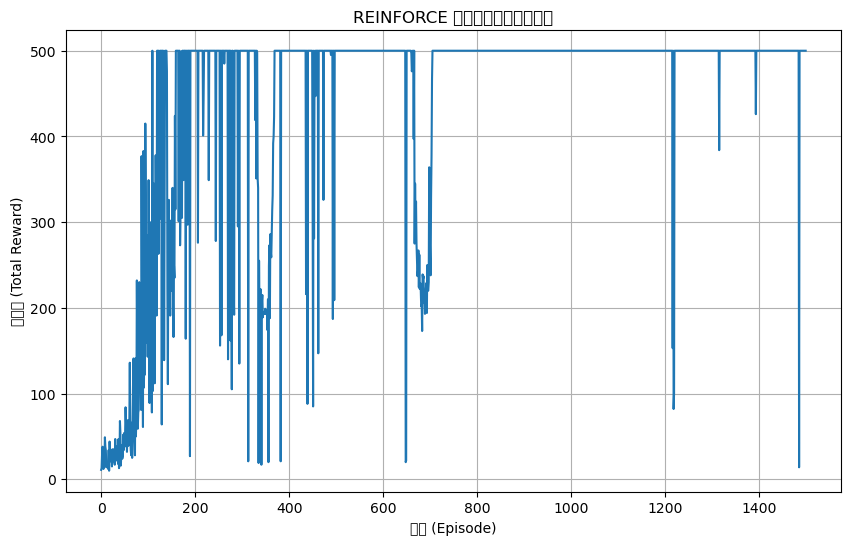

In [4]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    """评估训练好的智能体"""
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state, info = env.reset()
        total_rewards_ep = 0
        
        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward
            
            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

# 创建一个新的评估环境，并开启渲染模式
eval_env = gym.make(env_id, render_mode="human")
mean_reward, std_reward = evaluate_agent(eval_env, 
                                         cartpole_hyperparameters["max_t"], 
                                         cartpole_hyperparameters["n_evaluation_episodes"], 
                                         cartpole_policy)
print(f"平均奖励 = {mean_reward:.2f} +/- {std_reward:.2f}")

# 关闭环境窗口
eval_env.close()

# 绘制分数曲线
plt.figure(figsize=(10, 6))
plt.plot(scores)
plt.title('REINFORCE 训练过程中的分数变化')
plt.xlabel('回合 (Episode)')
plt.ylabel('总奖励 (Total Reward)')
plt.grid(True)
plt.show()